In [1]:
import numpy as np 
import os 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

/Users/anwesh/opt/anaconda3/envs/tf/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
data_path = '../../Smart attack Algorithm/data/Car Hacking Dataset/'
benign_data_path = os.path.join(data_path, 'benign_data.csv')
attack_data_path = os.path.join(data_path, 'DoS_dataset.csv')

In [3]:
def shift_columns(df):
    
    for dlc in [2,5,6]:

        df.loc[df['DLC'] == dlc, df.columns[3:]] = df.loc[df['DLC'] == dlc, df.columns[3:]].shift(periods=8-dlc, axis='columns', fill_value='00')

    return df
    

def read_ch_data(data_path):
    
    columns = ['Timestamp','ID', 'DLC', 'data0', 'data1', 'data2', 'data3', 'data4', 
           'data5', 'data6', 'data7', 'label']
    
    data = pd.read_csv(data_path, names = columns)

    data = shift_columns(data)
    
    ##Replacing all NaNs with '00' 
    data = data.replace(np.NaN, '00')
    
    ##Joining all data columns to put all data in one column
    data_cols = ['data0', 'data1', 'data2', 'data3', 'data4', 'data5', 'data6', 'data7']
    
    ##The data column is in hexadecimal
    data['Payload'] = data[data_cols].apply(''.join, axis=1)
    data.drop(columns = data_cols, inplace = True, axis = 1)
        
    data = data.assign(IAT=data['Timestamp'].diff().fillna(0))
    data = data[['Timestamp', 'ID','DLC','Payload', 'label']]
    data['label'].replace({'R' : 0, 'T' : 1}, inplace = True)
    
    return data


In [4]:
def data_len(df):
    if 'Timestamp' in df.columns:
        # Ensure the Timestamp column is sorted
        df = df.sort_values(by='Timestamp')
        
        # Compute time difference
        time_diff = df['Timestamp'].iloc[-1] - df['Timestamp'].iloc[0]
        
        # Convert to HH:MM:SS:Milliseconds format
        hours, remainder = divmod(time_diff, 3600)
        minutes, remainder = divmod(remainder, 60)
        seconds, milliseconds = divmod(remainder, 1)
        
        time_str = f"{int(hours):02}:{int(minutes):02}:{int(seconds):02}:{int(milliseconds * 1000):03}"
        
        return time_str
    else:
        return "Timestamp column not found in dataframe"

In [5]:
hex_to_dec = lambda x: int(x, 16)

def transform_data(data):

    data['ID'] = data['ID'].apply(hex_to_dec)
    data['Payload'] = data['Payload'].apply(hex_to_dec)

    return data

hex_to_dec = lambda x: int(x, 16)

# Function to handle conversion
def convert_hex_column(column):
    def convert_value(value):
        try:
            # Try to convert using hex_to_dec
            return hex_to_dec(value)
        except ValueError:
            # If ValueError occurs, it means the value is in scientific notation
            return int(float(value))
    
    return column.apply(convert_value)

In [6]:
benign_data = pd.read_csv(benign_data_path)
benign_data = transform_data(benign_data)
benign_data.head()

,Timestamp,ID,DLC,Payload,label
0,1.479121e+09,848,8,371692544708313250,0
1,1.479121e+09,704,8,1441151880758558720,0
2,1.479121e+09,1072,8,0,0
3,1.479121e+09,1201,8,0,0
4,1.479121e+09,497,8,0,0


In [7]:
dos_data = read_ch_data(attack_data_path)
dos_data = transform_data(dos_data)
dos_data.head()

/var/folders/pw/3vr89zzj1xvbzvtk1yfz9kkc0000gn/T/ipykernel_2787/2976669208.py:31: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['label'].replace({'R' : 0, 'T' : 1}, inplace = True)
/var/folders/pw/3vr89zzj1xvbzvtk1yfz9kkc0000gn/T/ipykernel_2787/2976669208.py:31: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasti

,Timestamp,ID,DLC,Payload,label
0,1.478198e+09,790,8,369691032840896623,0
1,1.478198e+09,399,8,18328243108518297600,0
2,1.478198e+09,608,8,1810766114876976442,0
3,1.478198e+09,672,8,7205928855671061760,0
4,1.478198e+09,809,8,4664461563235663892,0


In [8]:
def calculate_periodicity(data, return_df=False):
    """
    Periodicity is the time difference between two consecutive packets of the same ID.
    - For the first packet of each ID, the periodicity is 0.
    - For the first packet in the dataset the IAT will be 0.

    Parameters:
        data (pd.DataFrame): DataFrame with at least 'Timestamp' and 'ID' columns.
        return_df (bool): If True, returns original DataFrame with 'Periodicity' column.
                          If False, returns a dictionary with mean periodicity per ID.

    Returns:
        pd.DataFrame or dict
    """
    # Ensure Timestamp is in datetime format
    # data['Timestamp'] = pd.to_datetime(data['Timestamp'], unit='s')
    # Calculate periodicity as time difference within each ID
    data['Periodicity'] = data.groupby('ID')['Timestamp'].diff()
    # data['Periodicity'] = data.groupby('ID')['Timestamp'].diff().dt.total_seconds()
    data['Periodicity'] = data['Periodicity'].fillna(0)

    if return_df:
        return data
    else:
        ##Mean and std-dev of periodicity per ID in a dictionary, the key is the ID, the value is list of mean and std-dev
        periodicity_dict = {}
        for id_val in data['ID'].unique():
            periodicity_dict[id_val] = [data[data['ID'] == id_val]['Periodicity'].mean(), 
                                         data[data['ID'] == id_val]['Periodicity'].std()]
        
        return periodicity_dict

benign_periodicity = calculate_periodicity(benign_data)
dos_data = calculate_periodicity(dos_data, return_df=True)

Benign Periodicity Statistics:
ID: 339, Mean: 0.009999177579566997, Std: 0.0007820537988096879, Mean - Std: 0.009217123780757308, Mean + Std: 0.010781231378376685
ID: 2, Mean: 0.009999177405391085, Std: 0.0012198384165477273, Mean - Std: 0.008779338988843357, Mean + Std: 0.011219015821938813
ID: 1264, Mean: 0.01999901295009547, Std: 0.0004442851275148921, Mean - Std: 0.019554727822580577, Mean + Std: 0.020443298077610365


Attack Periodicity Statistics:
ID: 339, Mean: 0.020037625598573035, Std: 0.03815904793865347, Max: 1.0493440628051758, Min: 0.0
ID: 2, Mean: 0.01987748752705851, Std: 0.038027064833715506, Max: 1.5805048942565918, Min: 0.0
ID: 1264, Mean: 0.04091161290475105, Std: 0.09074681667149478, Max: 3.6950290203094482, Min: 0.0




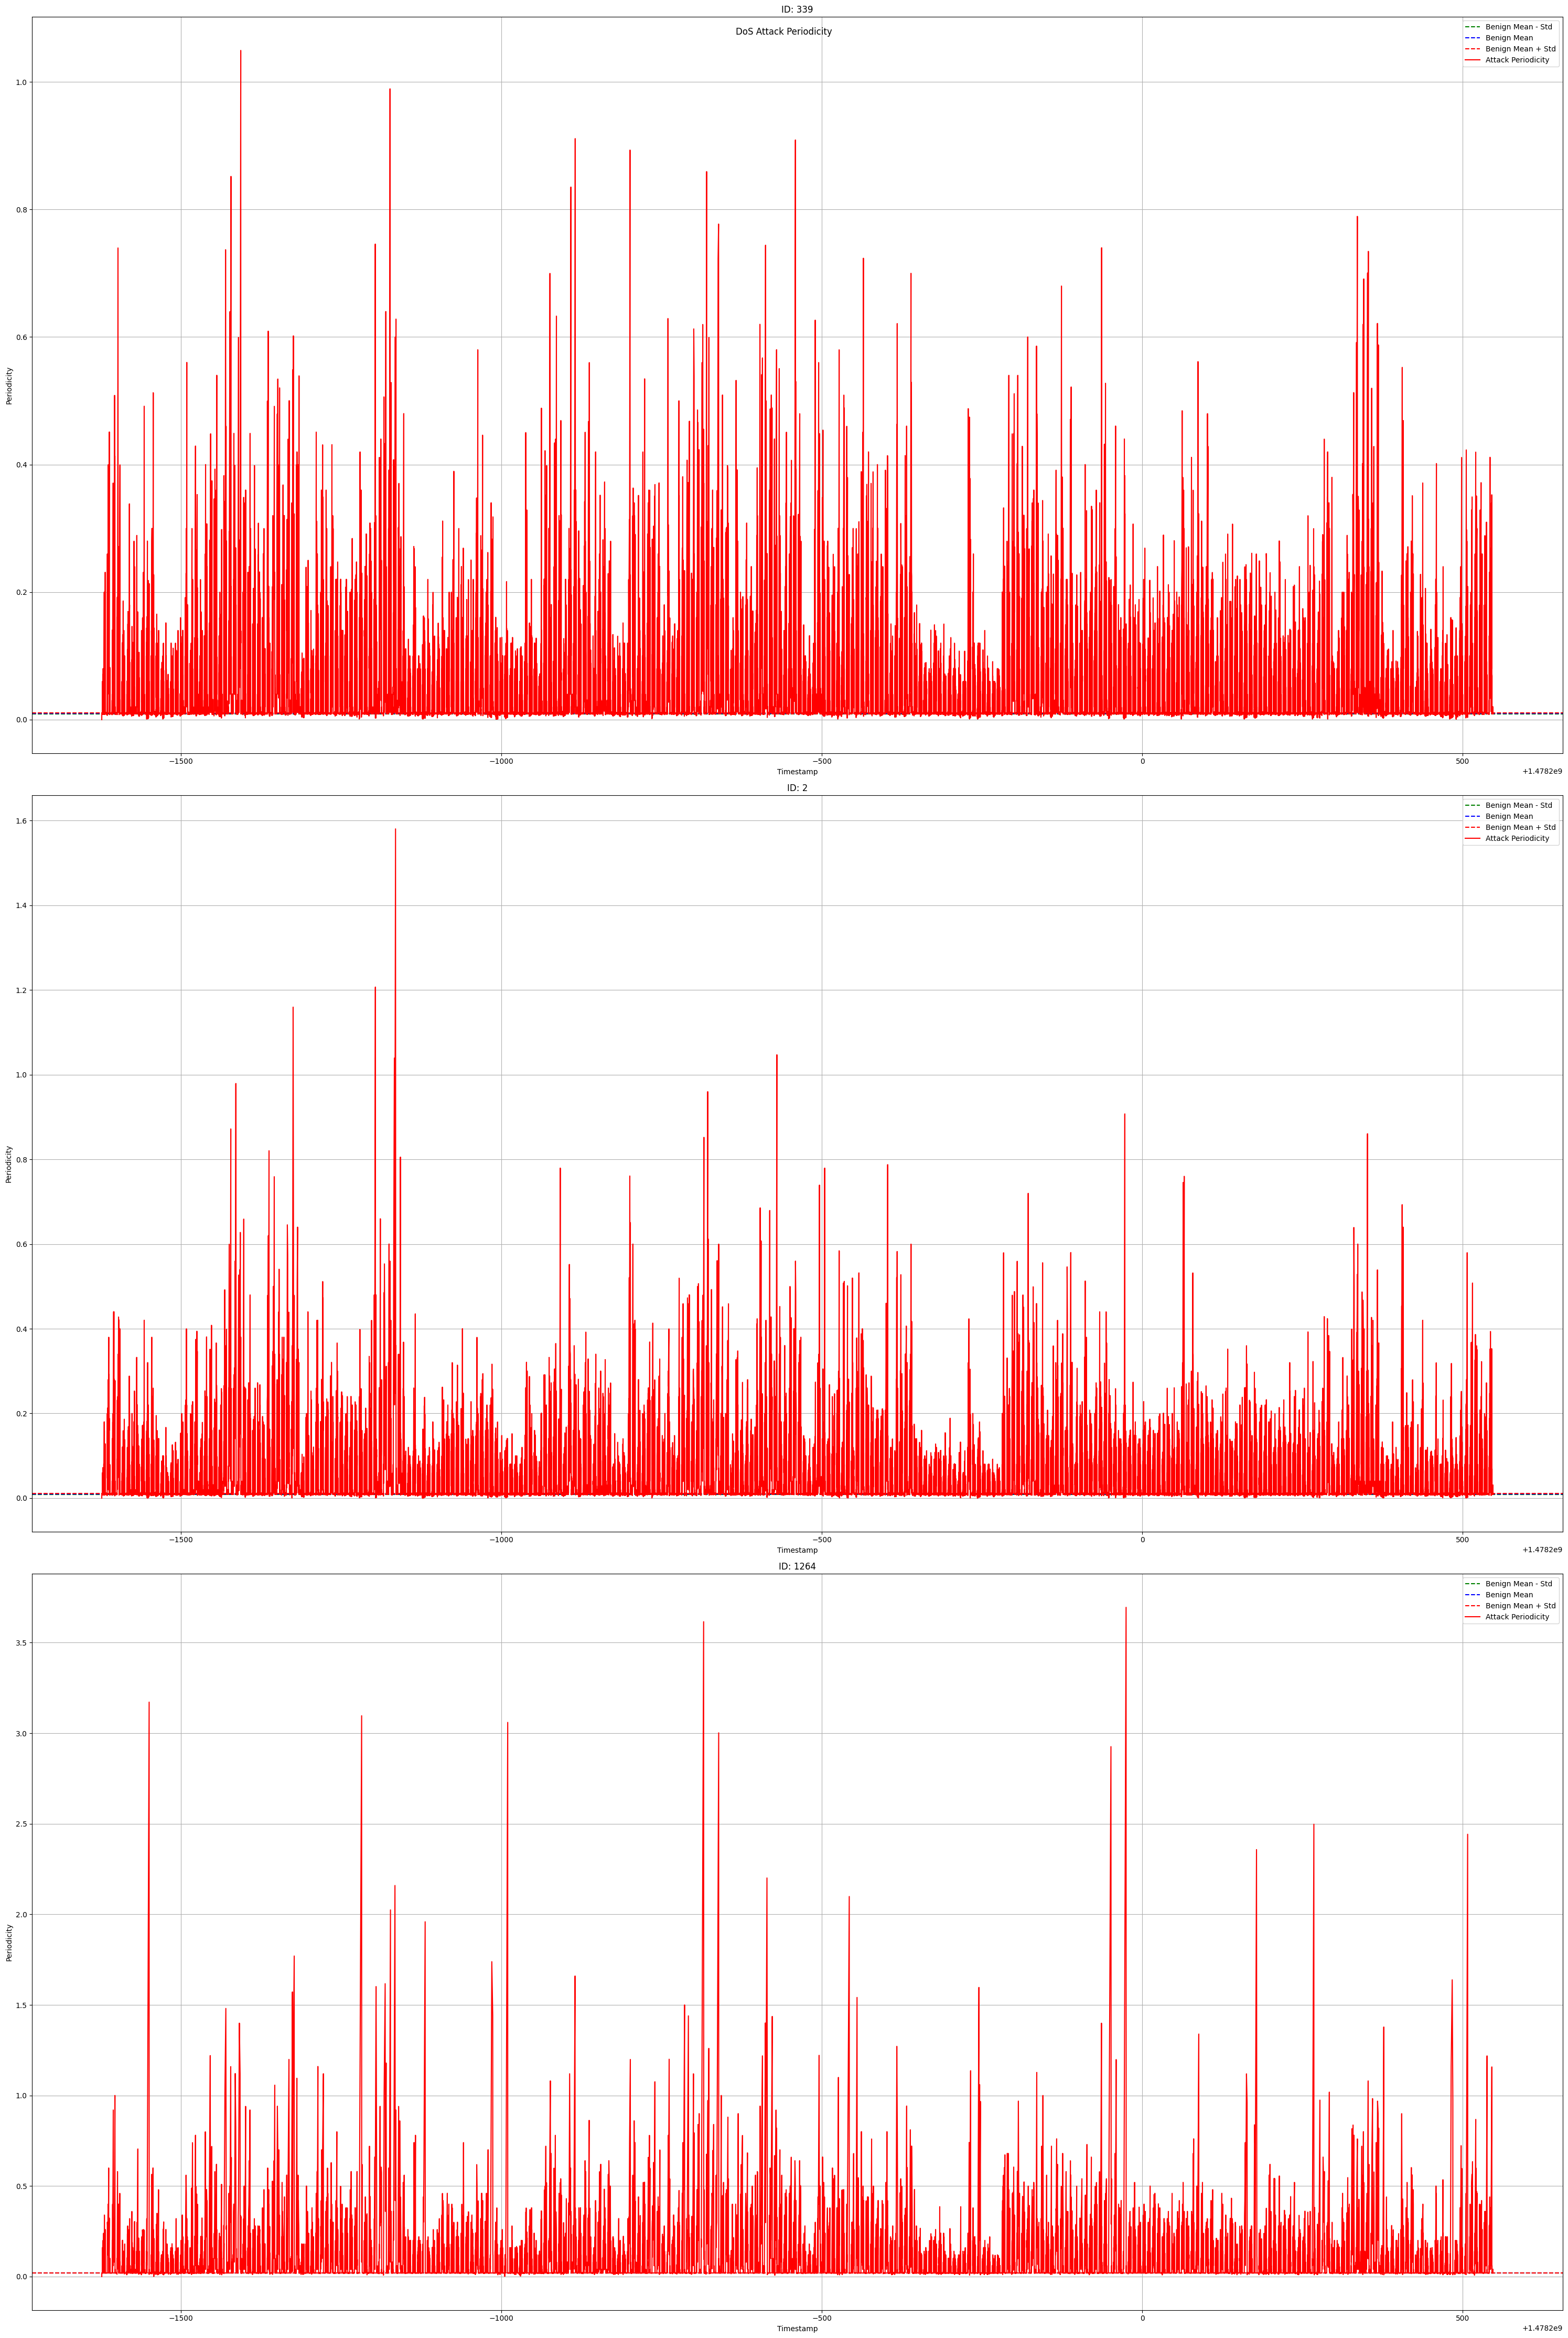

In [9]:
def plot_periodicity(attack_data, benign_periodicity_dict, title):
    
    ## Select 3 random IDs in the dataset
    ids = attack_data['ID'].unique()
    attack_data = attack_data[0:round(len(attack_data)  * 0.7)]
    ids = np.random.choice(ids, 3, replace=False)

    ##Plot a scatter plot for each ID, the x-axis is the Timestamp and the y-axis is the periodicity
    ## The periodicity of the attack data will be in red
    ## There will be three more lines parallel to x-axis on each plot
    ## The first line is the mean - std-dev periodicity of the benign data
    ## The second line is the mean periodicity of the benign data
    ## The third line is the mean + std-dev periodicity of the benign data
    ## Before plotting print the mean - std-dev, mean and mean + std-dev periodicity of the benign data
    print("Benign Periodicity Statistics:")
    for id_val in ids:
        benign_mean = benign_periodicity_dict[id_val][0]
        benign_std = benign_periodicity_dict[id_val][1]
        print(f"ID: {id_val}, Mean: {benign_mean}, Std: {benign_std}, Mean - Std: {benign_mean - benign_std}, Mean + Std: {benign_mean + benign_std}")
    print("\n")

    ##Print the mean - std-dev, mean and mean + std-dev periodicity of the attack data and max and min periodicity
    print("Attack Periodicity Statistics:")
    for id_val in ids:
        ##Only packets with label 1
        ##The periodicity of the attack data will be in red
        attack_mean = attack_data[attack_data['ID'] == id_val]['Periodicity'].mean()
        attack_std = attack_data[attack_data['ID'] == id_val]['Periodicity'].std()
        attack_max = attack_data[attack_data['ID'] == id_val]['Periodicity'].max()
        attack_min = attack_data[attack_data['ID'] == id_val]['Periodicity'].min()
        print(f"ID: {id_val}, Mean: {attack_mean}, Std: {attack_std}, Max: {attack_max}, Min: {attack_min}")
    print("\n")

    fig, axes = plt.subplots(3, 1, figsize=(30, 45))
    fig.suptitle(title)
    for i, id_val in enumerate(ids):
        ax = axes[i]
        ax.set_title(f"ID: {id_val}")
        
        # Plot benign periodicity
        benign_mean = benign_periodicity_dict[id_val][0]
        benign_std = benign_periodicity_dict[id_val][1]
        ax.axhline(y=benign_mean - benign_std, color='green', linestyle='--', label='Benign Mean - Std')
        ax.axhline(y=benign_mean, color='blue', linestyle='--', label='Benign Mean')
        ax.axhline(y=benign_mean + benign_std, color='red', linestyle='--', label='Benign Mean + Std')

        # Plot attack periodicity
        ##Trim the last part of the attack_dataset
        
        attack_data[attack_data['ID'] == id_val].plot(x='Timestamp', y='Periodicity', ax=ax, label='Attack Periodicity', color='red')
        ax.set_xlabel('Timestamp')
        ax.set_ylabel('Periodicity')
        ax.legend()
        ax.grid()
    plt.tight_layout()
    plt.show()

plot_periodicity(dos_data, benign_periodicity, 'DoS Attack Periodicity')


In [10]:
dos_data[dos_data['label'] == 1]

,Timestamp,ID,DLC,Payload,label,Periodicity
1476,1.478198e+09,0,8,0,1,0.000000
1478,1.478198e+09,0,8,0,1,0.000492
1480,1.478198e+09,0,8,0,1,0.000490
1482,1.478198e+09,0,8,0,1,0.000493
1484,1.478198e+09,0,8,0,1,0.000504
...,...,...,...,...,...,...
2675669,1.478201e+09,0,8,0,1,0.011183
2675670,1.478201e+09,0,8,0,1,0.005430
2675671,1.478201e+09,0,8,0,1,0.000496
2675674,1.478201e+09,0,8,0,1,0.000998


Using mean +/- std-dev
Accuracy: 0.7515
F1 Score: 0.5633
TPR: 1.0000
FPR: 0.2959
TNR: 0.7041
FNR: 0.0000

              precision    recall  f1-score   support

      Benign       1.00      0.70      0.83   3078250
      Attack       0.39      1.00      0.56    587521

    accuracy                           0.75   3665771
   macro avg       0.70      0.85      0.69   3665771
weighted avg       0.90      0.75      0.78   3665771



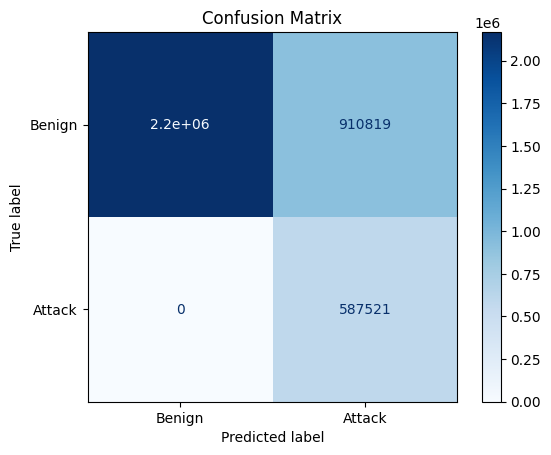

Using mean only
Accuracy: 0.6384
F1 Score: 0.4699
TPR: 1.0000
FPR: 0.4306
TNR: 0.5694
FNR: 0.0000

              precision    recall  f1-score   support

      Benign       1.00      0.57      0.73   3078250
      Attack       0.31      1.00      0.47    587521

    accuracy                           0.64   3665771
   macro avg       0.65      0.78      0.60   3665771
weighted avg       0.89      0.64      0.68   3665771



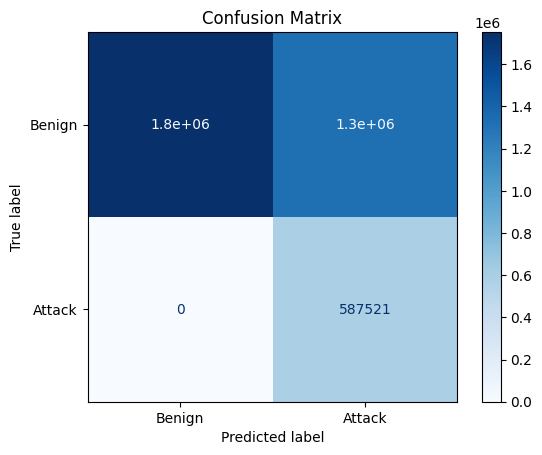

In [11]:
def make_predictions(benign_periodicity, dos_data, use_range=True):
   
    ##Make predictions per packet using benign_periodicity mean and std-dev
    ## For each packet in dos_data, check if the periodicity is within the mean +/- std-dev of the benign data

    predictions = []
    true_labels = dos_data['label'].values

    for index, row in dos_data.iterrows():
        id_val = row['ID']
        periodicity = row['Periodicity']

        if use_range:
            if id_val in benign_periodicity:
                mean, std_dev = benign_periodicity[id_val]
                lower_bound = mean - std_dev
                upper_bound = mean + std_dev

                if lower_bound <= periodicity <= upper_bound:
                    predictions.append(0)
                else:
                    predictions.append(1)
            else:
                predictions.append(1)
        else:
            if id_val in benign_periodicity:
                mean, _ = benign_periodicity[id_val]
                if periodicity < mean:
                    predictions.append(1)
                else:
                    predictions.append(0)
            else:
                predictions.append(1) 
        
    if use_range:
        print("Using mean +/- std-dev")
    else:
        print("Using mean only")

    ##Convert predictions to numpy array
    predictions = np.array(predictions)
    true_labels = np.array(true_labels)

    ##Calculate and print accuracy, F1 Score, TPR, FPR, TNR, FNR
    TP = np.sum((predictions == 1) & (true_labels == 1))
    TN = np.sum((predictions == 0) & (true_labels == 0))
    FP = np.sum((predictions == 1) & (true_labels == 0))
    FN = np.sum((predictions == 0) & (true_labels == 1))

    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    TPR = recall  # True Positive Rate
    FPR = FP / (FP + TN) if (FP + TN) > 0 else 0  # False Positive Rate
    TNR = TN / (TN + FP) if (TN + FP) > 0 else 0  # True Negative Rate
    FNR = FN / (TP + FN) if (TP + FN) > 0 else 0  # False Negative Rate

    #Print results
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1_score:.4f}")
    print(f"TPR: {TPR:.4f}")
    print(f"FPR: {FPR:.4f}")
    print(f"TNR: {TNR:.4f}")
    print(f"FNR: {FNR:.4f}")

    print("")
    print(classification_report(true_labels, predictions, target_names=['Benign', 'Attack']))

    ##Plot confusion matrix with seaborn
    cm = confusion_matrix(true_labels, predictions)
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Attack'])
    cm_display.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

    return predictions

range_preds = make_predictions(benign_periodicity, dos_data, use_range=True)
mean_preds = make_predictions(benign_periodicity, dos_data, use_range=False)

In [12]:
dos_data['Preds'] = range_preds

##Print the rows where label is 0 and prediction is 1 and periodicity is not 0
benign_dos = dos_data[(dos_data['label'] == 0) & (dos_data['Preds'] == 1) & (dos_data['Periodicity'] != 0)]
benign_dos = benign_dos[['ID', 'DLC', 'Payload', 'Periodicity', 'label', 'Preds']]

In [13]:
#For each key in in benign_periodicity print mean-std-dev | mean | mean + std-dev
for key in benign_periodicity.keys():
    mean, std_dev = benign_periodicity[key]
    print(f"{key}: {mean-std_dev} | {mean+std_dev}")
    

848: 0.009625096645066092 | 0.010367810401593834
704: 0.009671848620754918 | 0.010310065954371039
1072: 0.019766941824465405 | 0.020228982126918118
1201: 0.019724677821605033 | 0.02027124368194914
497: 0.019731492395154013 | 0.02026442839288081
339: 0.009217123780757308 | 0.010781231378376685
2: 0.008779338988843357 | 0.011219015821938813
399: 0.009543355482987093 | 0.010439445156974836
304: 0.008754226449828893 | 0.01124415141807809
305: 0.008757410786672566 | 0.011240965744316605
320: 0.00875769102237212 | 0.011240685037871342
608: 0.009501076872365772 | 0.010481694491504922
672: 0.00945177021388135 | 0.010531001300509093
790: 0.009243162363054757 | 0.010739573017188376
809: 0.00937545461633832 | 0.010607308355034048
1349: 0.009365051147751293 | 0.010617711588429328
688: 0.009697882074511648 | 0.010316725284851343
1087: 0.009504448714150616 | 0.010496057278425196
880: 0.009566883143234695 | 0.010433603584144425
1088: 0.009466830433578127 | 0.010533665370853589
1264: 0.019554727822580

In [14]:
##Now we will do frequency mode analysis for every ID
## Frequency for each packet is defined as the number of packets with the same ID in the dataset, in a given time period
## For the first packet of each ID, the frequency is 0.
## For the benign data we will generate frequency for each unique ID, (timestamp of last packet - timestamp of first packet)/num_packets
## And return in a dictionary

def generate_benign_frequencies(benign_data):
    """
    Function to generate frequency for each unique ID in the benign data
    Frequency is defined as (timestamp of last packet - timestamp of first packet)/num_packets
    """

    # Ensure Timestamp is in datetime format
    # benign_data['Timestamp'] = pd.to_datetime(benign_data['Timestamp'], unit='s')

    frequency_dict = {}
    
    for id_val in benign_data['ID'].unique():
        id_data = benign_data[benign_data['ID'] == id_val]
        num_packets = len(id_data)
        time_diff = id_data['Timestamp'].iloc[-1] - id_data['Timestamp'].iloc[0]
        frequency = time_diff / num_packets
        frequency_dict[id_val] = frequency

    return frequency_dict

benign_frequencies = generate_benign_frequencies(benign_data)


In [15]:
print(benign_frequencies)

{848: 0.009996453523329963, 704: 0.009990957287562979, 1072: 0.01999796197569176, 1201: 0.019997960751777087, 497: 0.01999796039401741, 339: 0.009999177579566997, 2: 0.009999177405391085, 399: 0.009991400319980965, 304: 0.009999188933953492, 305: 0.009999188265494586, 320: 0.00999918803012173, 608: 0.009991385681935347, 672: 0.009991385757195222, 790: 0.009991367690121567, 809: 0.009991381485686185, 1349: 0.00999138136809031, 688: 0.010007303679681495, 1087: 0.010000252996287906, 880: 0.01000024336368956, 1088: 0.010000247902215858, 1264: 0.01999901295009547, 1520: 0.04999470946136544, 1440: 0.9971439899542393, 1442: 0.9971437632920004, 1680: 0.09997924898661331, 160: 0.09989665132295267, 161: 0.0998966476064831}


In [16]:
dos_data.drop(['Preds'], axis=1, inplace=True)
def generate_attack_frequencies(attack_data, time_period):
    """
    For each packet in attack_data, calculate frequency as:
    Number of packets with the same ID in the past `time_period` seconds.
    """
    # Ensure timestamps are in datetime format and data is sorted
    attack_data['Timestamp'] = pd.to_datetime(attack_data['Timestamp'], unit='s')
    # attack_data = attack_data.sort_values(['ID', 'Timestamp']).reset_index(drop=True)
    
    # Initialize the frequency column
    attack_data['Frequency'] = 0.0

    # Group by ID for efficient processing
    grouped = attack_data.groupby('ID')

    result = []

    for id_val, group in grouped:
        timestamps = group['Timestamp'].values.astype('datetime64[s]').astype('int64')
        freq_list = []
        start = 0
        
        for i in range(len(timestamps)):
            # Move start index to maintain the window
            while timestamps[i] - timestamps[start] > time_period:
                start += 1
            freq_list.append(i - start)  # number of previous packets in window

        group['Frequency'] = freq_list
        result.append(group)

    attack_data = pd.concat(result).sort_index()
    return attack_data



In [17]:
def generate_predictions(attack_data, time_period):

    attack_data_frequencies = generate_attack_frequencies(attack_data, time_period=time_period)

    labels = attack_data_frequencies['label'].values
    predictions = []

    for idx, row in attack_data_frequencies.iterrows():
        id = row['ID']
        frequency = row['Frequency']

        if id in benign_frequencies:
            if frequency > 2 * benign_frequencies[id]:
                predictions.append(1)
            else:
                predictions.append(0)
        else:
            predictions.append(1)

    predictions = np.array(predictions)

    ##Calculate and print accuracy, F1 Score, TPR, FPR, TNR, FNR
    TP = np.sum((predictions == 1) & (labels == 1))
    TN = np.sum((predictions == 0) & (labels == 0))
    FP = np.sum((predictions == 1) & (labels == 0))
    FN = np.sum((predictions == 0) & (labels == 1))

    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    TPR = recall  # True Positive Rate
    FPR = FP / (FP + TN) if (FP + TN) > 0 else 0  # False Positive Rate
    TNR = TN / (TN + FP) if (TN + FP) > 0 else 0  # True Negative Rate
    FNR = FN / (TP + FN) if (TP + FN) > 0 else 0  # False Negative Rate

    #Print results
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1_score:.4f}")
    print(f"TPR: {TPR:.4f}")
    print(f"FPR: {FPR:.4f}")
    print(f"TNR: {TNR:.4f}")
    print(f"FNR: {FNR:.4f}")

    print("")
    print(classification_report(labels, predictions, target_names=['Benign', 'Attack']))

    ##Plot confusion matrix with seaborn
    cm = confusion_matrix(labels, predictions)
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Attack'])
    cm_display.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()


Time Period: 1e-06 seconds
Accuracy: 0.1792
F1 Score: 0.2809
TPR: 1.0000
FPR: 0.9774
TNR: 0.0226
FNR: 0.0000

              precision    recall  f1-score   support

      Benign       1.00      0.02      0.04   3078250
      Attack       0.16      1.00      0.28    587521

    accuracy                           0.18   3665771
   macro avg       0.58      0.51      0.16   3665771
weighted avg       0.87      0.18      0.08   3665771



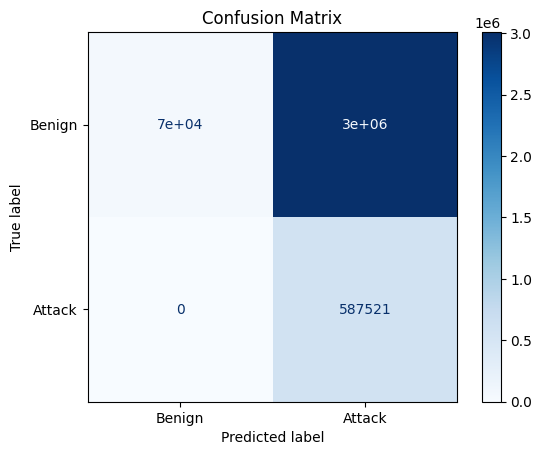



Time Period: 1e-05 seconds
Accuracy: 0.1792
F1 Score: 0.2809
TPR: 1.0000
FPR: 0.9774
TNR: 0.0226
FNR: 0.0000

              precision    recall  f1-score   support

      Benign       1.00      0.02      0.04   3078250
      Attack       0.16      1.00      0.28    587521

    accuracy                           0.18   3665771
   macro avg       0.58      0.51      0.16   3665771
weighted avg       0.87      0.18      0.08   3665771



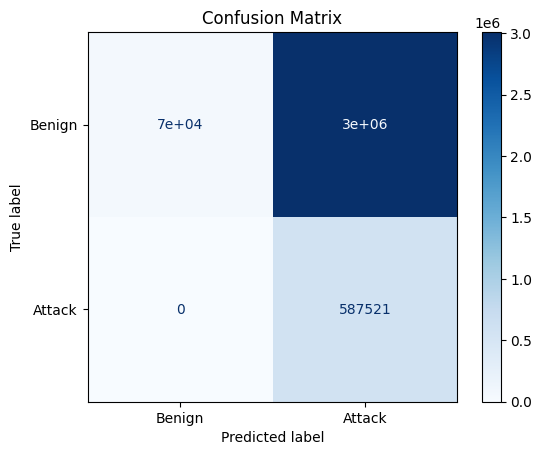



Time Period: 0.0001 seconds
Accuracy: 0.1792
F1 Score: 0.2809
TPR: 1.0000
FPR: 0.9774
TNR: 0.0226
FNR: 0.0000

              precision    recall  f1-score   support

      Benign       1.00      0.02      0.04   3078250
      Attack       0.16      1.00      0.28    587521

    accuracy                           0.18   3665771
   macro avg       0.58      0.51      0.16   3665771
weighted avg       0.87      0.18      0.08   3665771



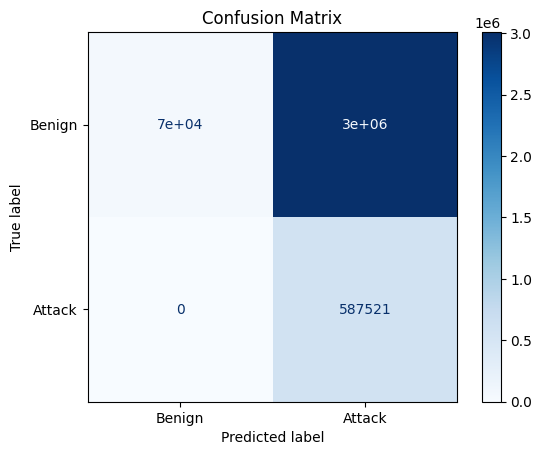



Time Period: 0.001 seconds
Accuracy: 0.1792
F1 Score: 0.2809
TPR: 1.0000
FPR: 0.9774
TNR: 0.0226
FNR: 0.0000

              precision    recall  f1-score   support

      Benign       1.00      0.02      0.04   3078250
      Attack       0.16      1.00      0.28    587521

    accuracy                           0.18   3665771
   macro avg       0.58      0.51      0.16   3665771
weighted avg       0.87      0.18      0.08   3665771



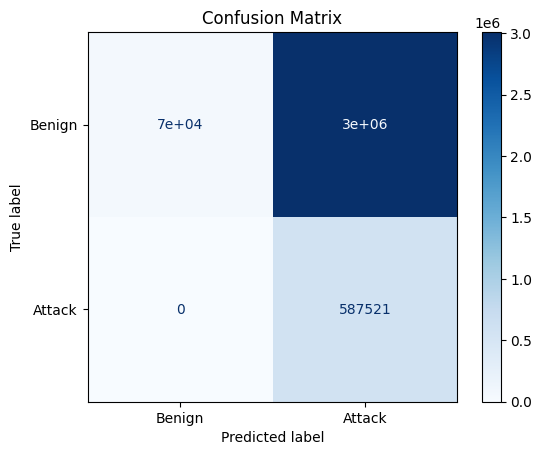



Time Period: 0.01 seconds
Accuracy: 0.1792
F1 Score: 0.2809
TPR: 1.0000
FPR: 0.9774
TNR: 0.0226
FNR: 0.0000

              precision    recall  f1-score   support

      Benign       1.00      0.02      0.04   3078250
      Attack       0.16      1.00      0.28    587521

    accuracy                           0.18   3665771
   macro avg       0.58      0.51      0.16   3665771
weighted avg       0.87      0.18      0.08   3665771



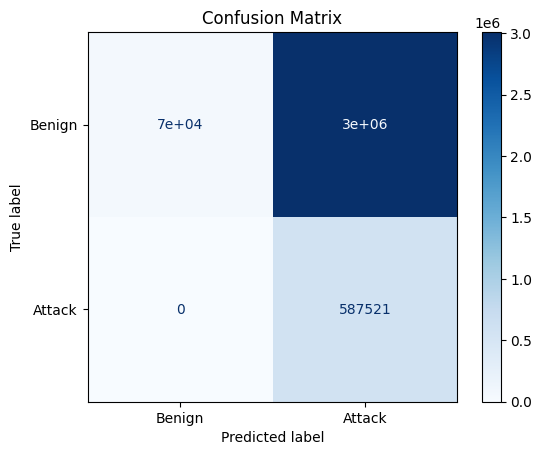



Time Period: 0.1 seconds
Accuracy: 0.1792
F1 Score: 0.2809
TPR: 1.0000
FPR: 0.9774
TNR: 0.0226
FNR: 0.0000

              precision    recall  f1-score   support

      Benign       1.00      0.02      0.04   3078250
      Attack       0.16      1.00      0.28    587521

    accuracy                           0.18   3665771
   macro avg       0.58      0.51      0.16   3665771
weighted avg       0.87      0.18      0.08   3665771



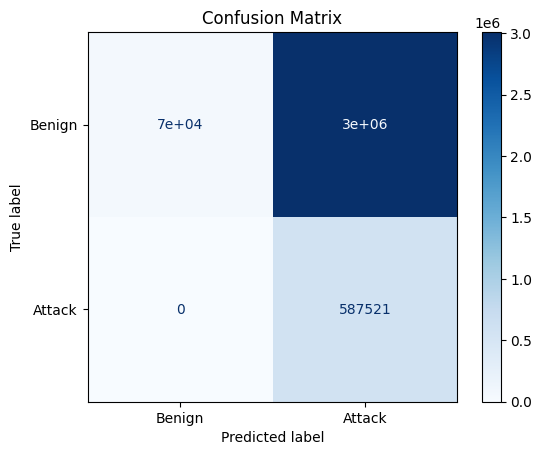



Time Period: 0.5 seconds
Accuracy: 0.1792
F1 Score: 0.2809
TPR: 1.0000
FPR: 0.9774
TNR: 0.0226
FNR: 0.0000

              precision    recall  f1-score   support

      Benign       1.00      0.02      0.04   3078250
      Attack       0.16      1.00      0.28    587521

    accuracy                           0.18   3665771
   macro avg       0.58      0.51      0.16   3665771
weighted avg       0.87      0.18      0.08   3665771



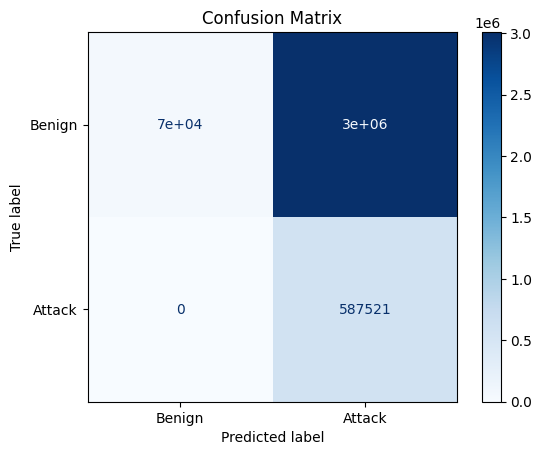



Time Period: 1 seconds
Accuracy: 0.1614
F1 Score: 0.2765
TPR: 1.0000
FPR: 0.9987
TNR: 0.0013
FNR: 0.0000

              precision    recall  f1-score   support

      Benign       1.00      0.00      0.00   3078250
      Attack       0.16      1.00      0.28    587521

    accuracy                           0.16   3665771
   macro avg       0.58      0.50      0.14   3665771
weighted avg       0.87      0.16      0.05   3665771



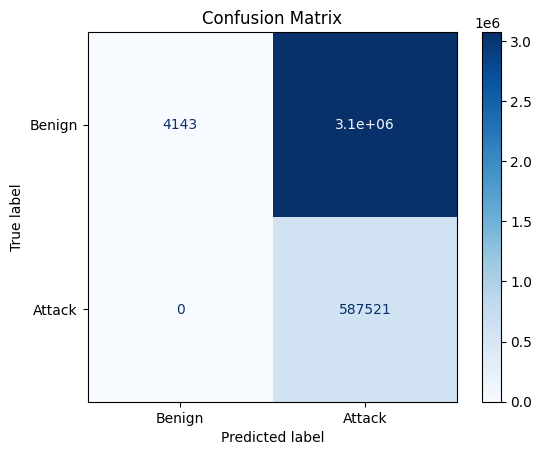



Time Period: 2 seconds
Accuracy: 0.1607
F1 Score: 0.2764
TPR: 1.0000
FPR: 0.9995
TNR: 0.0005
FNR: 0.0000

              precision    recall  f1-score   support

      Benign       1.00      0.00      0.00   3078250
      Attack       0.16      1.00      0.28    587521

    accuracy                           0.16   3665771
   macro avg       0.58      0.50      0.14   3665771
weighted avg       0.87      0.16      0.05   3665771



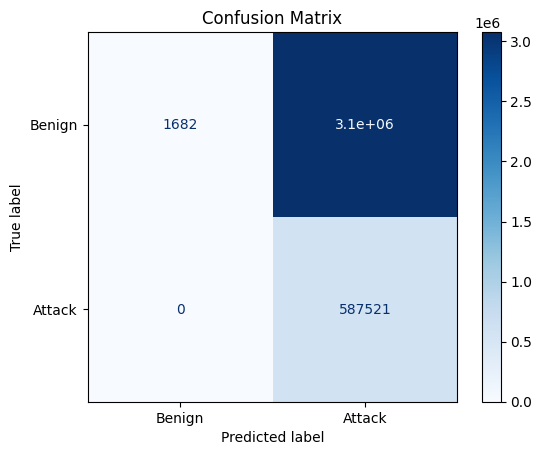



Time Period: 5 seconds
Accuracy: 0.1605
F1 Score: 0.2763
TPR: 1.0000
FPR: 0.9997
TNR: 0.0003
FNR: 0.0000

              precision    recall  f1-score   support

      Benign       1.00      0.00      0.00   3078250
      Attack       0.16      1.00      0.28    587521

    accuracy                           0.16   3665771
   macro avg       0.58      0.50      0.14   3665771
weighted avg       0.87      0.16      0.04   3665771



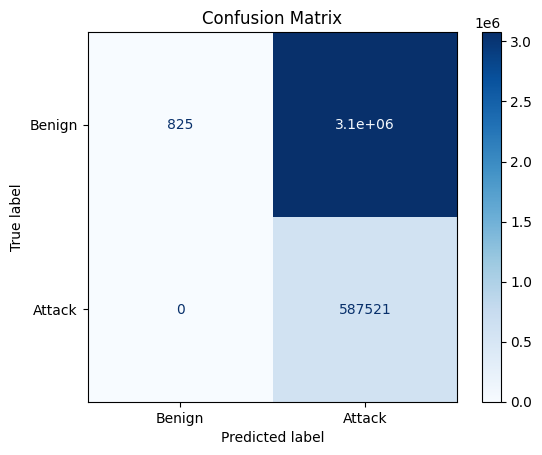



Time Period: 10 seconds
Accuracy: 0.1603
F1 Score: 0.2763
TPR: 1.0000
FPR: 1.0000
TNR: 0.0000
FNR: 0.0000

              precision    recall  f1-score   support

      Benign       1.00      0.00      0.00   3078250
      Attack       0.16      1.00      0.28    587521

    accuracy                           0.16   3665771
   macro avg       0.58      0.50      0.14   3665771
weighted avg       0.87      0.16      0.04   3665771



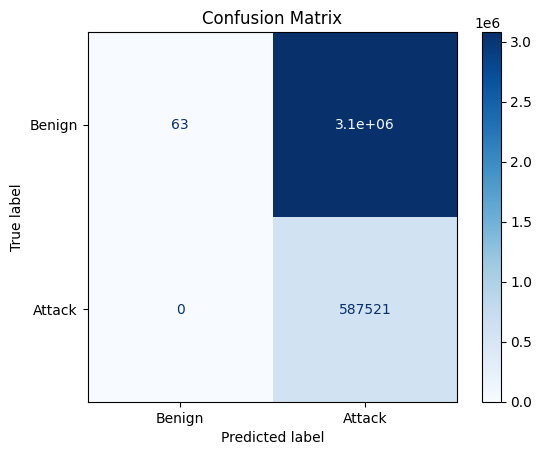



Time Period: 20 seconds
Accuracy: 0.1603
F1 Score: 0.2763
TPR: 1.0000
FPR: 1.0000
TNR: 0.0000
FNR: 0.0000

              precision    recall  f1-score   support

      Benign       1.00      0.00      0.00   3078250
      Attack       0.16      1.00      0.28    587521

    accuracy                           0.16   3665771
   macro avg       0.58      0.50      0.14   3665771
weighted avg       0.87      0.16      0.04   3665771



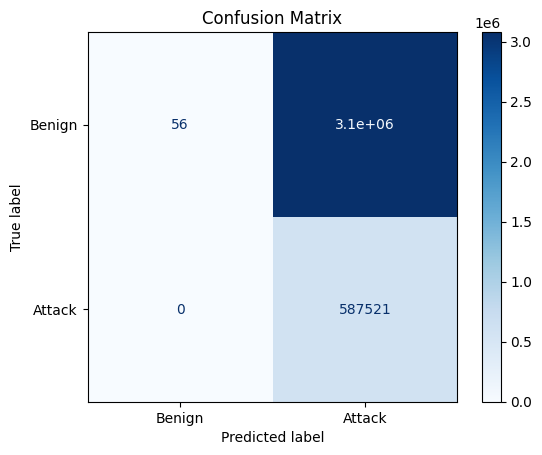



Time Period: 30 seconds
Accuracy: 0.1603
F1 Score: 0.2763
TPR: 1.0000
FPR: 1.0000
TNR: 0.0000
FNR: 0.0000

              precision    recall  f1-score   support

      Benign       1.00      0.00      0.00   3078250
      Attack       0.16      1.00      0.28    587521

    accuracy                           0.16   3665771
   macro avg       0.58      0.50      0.14   3665771
weighted avg       0.87      0.16      0.04   3665771



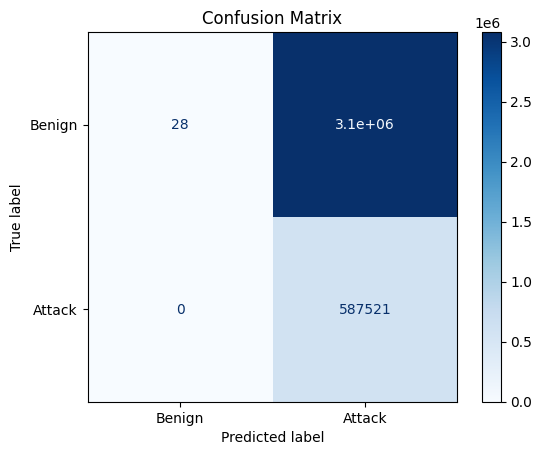



Time Period: 60 seconds
Accuracy: 0.1603
F1 Score: 0.2763
TPR: 1.0000
FPR: 1.0000
TNR: 0.0000
FNR: 0.0000

              precision    recall  f1-score   support

      Benign       1.00      0.00      0.00   3078250
      Attack       0.16      1.00      0.28    587521

    accuracy                           0.16   3665771
   macro avg       0.58      0.50      0.14   3665771
weighted avg       0.87      0.16      0.04   3665771



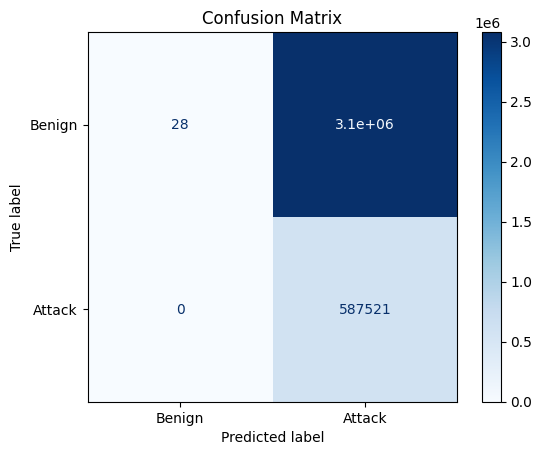



Time Period: 120 seconds
Accuracy: 0.1603
F1 Score: 0.2763
TPR: 1.0000
FPR: 1.0000
TNR: 0.0000
FNR: 0.0000

              precision    recall  f1-score   support

      Benign       1.00      0.00      0.00   3078250
      Attack       0.16      1.00      0.28    587521

    accuracy                           0.16   3665771
   macro avg       0.58      0.50      0.14   3665771
weighted avg       0.87      0.16      0.04   3665771



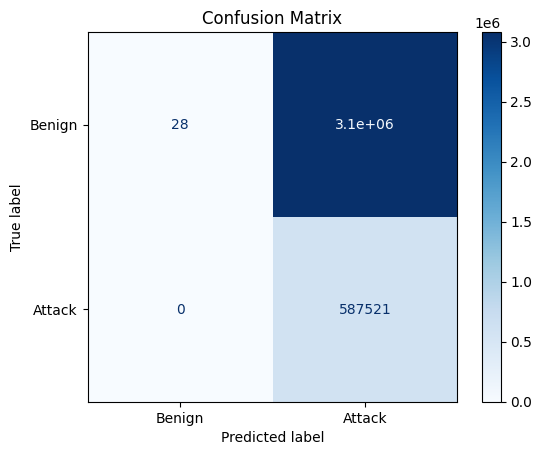



Time Period: 180 seconds


KeyboardInterrupt: 

In [18]:
time_periods = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2,0.1, 0.5, 1, 2, 5, 10, 20, 30, 60, 120, 180, 240, 300] # in seconds

for time_period in time_periods:
    print(f"Time Period: {time_period} seconds")
    generate_predictions(dos_data, time_period)
    print("\n" + "="*50 + "\n")